In [5]:
# imports: need plots?, simulation?
import numpy as np
import pandas as pd
import igraph as ig
import dowhy as dw
import matplotlib.pyplot as plt
import automates.model_analysis.identification_algorithms as ia

# DoWhy Confounding Example

## Objectives
There are two goals:
1. Illustrate that estimating an unidentifiable effect leads to incorrect decisions
2. Illustrate that ignoring known confounding rather than correcting for it leads to incorrect decisions

I will construct examples that highlight why, under certain conditions, ignoring information about identifiability gained from graph structure can lead to incorrect conclusions.

## Example 1: The Bow-Arc Graph
The bow-arc graph is the smallest unidentifiable graph (Shiptser and Pearl, page 1949), so let us examine this model first.

Suppose that we want to study the relationship between the force (F) when an object hits the ground when dropped from different heights (H). We select a number of objects and drop them and measure the force and record the height from which it is dropped. 

However, let us suppose that our objects do not all have the same mass and let us make the naive assumption that we cannot measure the mass. We then recognize that there is an unobserved confounder between height and force.

The Structural Causal Model (SCM) has the following structural equations:

\begin{align*} 
U &= f_U(\varepsilon_U) \\
H &= f_H(\varepsilon_H) \\
F &= f_F(U, H, \varepsilon_F), \text{ where } \varepsilon_U \perp \varepsilon_H \perp \varepsilon_F
\end{align*}

The graph corresponding to the scenario:

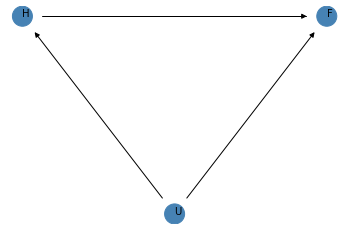

In [30]:
# Specify iGraph
g1 = ig.Graph(edges=[[0, 1], [2, 1], [2, 0]], directed=True)
g1.vs["name"] = ["H", "F", "U"]; g1.vs["description"] = ["O", "O", "U"]
g1.es["description"] = ["O", "U", "U"]

# plot graph
v_style1 = {"vertex_label": g1.vs["name"], "vertex_size": 20, "layout": g1.layout("rt", mode="all", root=[2])}
fig, ax = plt.subplots(); plt.axis('off')
ig.plot(g1, target=ax, **v_style1)

### Simulation
I sample from the following error distributions:
\begin{matrix}


\end{\matrix}
*latex distributions of errors*

Then construct the observations and outcome using the following structural equations for the graph:
*latex structural equations to be used*

This is repeated *n_samples* times:

In [31]:
# sample n times from error distributions
# construct observations and outcomes

### Identification, ID-Algorithm
Suppose we implement *reference* ID-Algorithm.

In [33]:
# Implement ID Algorithm on the Graph
ia.identifiability(["F"], ["H"], g1)

KeyError: 'Attribute does not exist'

We see that the effect *latex representation of effect* is not identifiable by the ID-Algorithm.

### Identification, DoWhy
Now, using DoWhy, I input the graph and data (DoWhy requires that data be bundled with the graph) and then run DoWhy's identification step.

In [ ]:
# specify DoWhy model
# implement DoWhy identification

We see that DoWhy warns us about the assumptions it's making, but proceeds anyway. It returns a regression coefficient as the "identified" value.

### Estimation, DoWhy
If we ignore DoWhy's warning and proceed with estimation (using linear regression) anyway, we get the following

In [ ]:
# implement DoWhy linear estimation method
# return output of interest

From the equations we used to simulate the data, we know that the true causal effect is:
*latex causal effect*

However, the estimation from DoWhy is *DoWhy results*. It is clear that this is not a very good estimate of the causal effect.

## Example 2